# Skip-gram word2vec

이 노트북은, TensorFlow 의 word2vec algorithm중 skip-gram의 아키텍처를 설명하기 위함입니다. 당신은 자연어처리의 단어의 embedding 개념을 알게 될 겁니다.


## Readings

다음과 같은 참고자료가 있습니다. 
* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)


## Word embeddings

#### Sparse Matrix의 문제점

텍스트의 단어를 다룰 때, 각 단어에 대해 하나씩, 수만 개의 클래스를 예측하게됩니다. 이 단어들을 한 번 핫 인코딩하는 것은 대단히 비효율적입니다. 하나의 요소를 1로 설정하고 나머지 50,000을 0으로 설정합니다. 첫 번째 숨겨진 레이어로가는 행렬 곱셈은 거의 모든 결과 값이 0이됩니다. 이것은 엄청난 계산 낭비입니다.

![one-hot encodings](assets/one_hot_encoding.png)

이 문제를 해결하고 네트워크의 효율성을 크게 높이기 위해 임베딩이라고하는 것을 사용합니다. Embedding은 fully connected layer입니다. 이 레이어를 this layer the embedding layer 가중치는 the weights are embedding weights.라고 합니다. 대신에 우리는 임베딩 레이어와 히든 레이어와의 곱을 건너뜁니다. 가중치 메트릭스를 통해서이죠. 원 핫 코드 벡터를 행렬에 곱하면 "on"입력 단위의 인덱스에 해당하는 행이 반환되기 때문에 이러한 연산이 가능합니다.

## Lookup table

![lookup](assets/lookup_matrix.png)

우리는 행렬곱셈 대신에, 가중치 매트릭스를 lookup table을 사용합니다. 우리는 id 값에 단어를 인코딩합니다. 예를 들어 "heart"는 958로, "mind"는 18094로 인코딩됩니다. 그런 다음 "heart"에 대한 숨겨진 레이어 값을 얻으려면 삽입 행렬의 958 번째 행을 가져옵니다. 이 과정을 **embedding lookup** 이라고 하며, 숨겨진 유닛을 **embedding dimension**라고 합니다.

<img src='assets/tokenize_lookup.png' width=500>
 
The embedding lookup table 은 그냥 가중치 매트릭스라고 생각하면 됩니다. 임베딩 레이어는 hidden layer입니다. lookup 은 행렬곱의 shortcut이라고 생각하면 됩니다. lookup table 의 학습은 가중치 행렬과 마찬가지로 진행됩니다.
<br>

Embedding은 물론 단어에 사용되는 것은 아닙니다. 방대한 수의 클래스가있는 모델에는이 모델을 사용할 수 있습니다. **Word2Vec** 라는 특정 유형의 모델은 의미 적 의미를 포함하는 단어의 벡터 표현을 찾기 위해 임베디드 레이어를 사용합니다.

## Word2Vec

word2vec 알고리즘은 단어를 나타내는 벡터를 찾아 훨씬 더 효율적인 표현을 찾습니다. 이 벡터는 또한 단어에 대한 의미론적 정보를 포함합니다. "검은 색", "흰색"및 "빨간색"과 같은 유사한 문맥에 나타나는 단어는 서로 가깝게 벡터를 갖습니다. CBOW (Continuous Bag-Of-Words) 및 Skip-gram을 구현하는 데는 두 가지 아키텍처가 있습니다.

<img src="assets/word2vec_architectures.png" width="500">

Skip-gram 아키텍처의 경우, 단어를 둘러싼 단어를 예측합니다. 비슷한 맥락에서 나타나는 단어 표현을 배우기 위해 네트워크를 훈련시킵니다.

In [1]:
import time

import numpy as np
import tensorflow as tf
import requests
import json
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from pymongo import MongoClient

import utils

In [5]:
client = MongoClient()
db = client.aboutdepart
database = list(db.Docdb.find())
testdf = pd.DataFrame(database)
testdf.head()

## Preprocessing

전처리과정은 모형의 학습을 돕기위해 진행됩니다 `preprocess` 함수는 임의의 구두점을 토큰으로 덮어주기 때문에 마침표는 `<PERIOD>`로 바뀝니다. 이 데이터 세트에는 마침표가 없지만 다른 NLP 문제에 도움이됩니다. 또한 데이터 집합에서 5 회 이하로 나타나는 모든 단어를 제거합니다. 이렇게하면 데이터의 노이즈로 인한 문제를 크게 줄이고 벡터 표현의 품질을 향상시킬 수 있습니다. 프로젝트 성격에 따라 적당히 수정하시길!

In [7]:
word = []
for i in testdf['text']:
    word.append(i)

In [9]:
words = utils.preprocess(str(word))
print(words[:30])

["entrepreneurs\\'", 'decisions', 'to', 'exploit', 'opportunities', "entrepreneurs\\'", 'decisions', 'to', 'exploit', 'opportunities', 'nan', 'family', 'ownership', 'and', 'r&d', 'investment', '<COLON>', 'the', 'role', 'of', 'growth', 'opportunities', 'and', 'business', 'group', 'this', 'study', 'examines', 'whether', 'the']


In [11]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 2983428
Unique words: 21522


이제 단어를 id로, 그리고 정수를 단어로 mapping 시켜 dictionary를 제작해야합니다. id 값은 정수로 내림차순으로 할당되므로 빈번한 단어는 0번째에 해당되며, int_words에 저장됩니다.

In [12]:
# look-up table 구축, tokenize 된 단어를 id 에 맵핑한다 생각해라
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

-----

## Subsampling

단어들중 빈출단어와, 문장 내 의미를 형성하지 않는 단어를 제거하는 것이 필요합니다. 일부 소음을 제거하고 더 정확한 표현을 할 수 있습니다.


$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

여기서 $t$ 는 threshold를 잡아주는 변수입니다. $f(w_i)$ 는 단어 $w_i$가 전체 데이터셋에서 가지는 빈도를 당담합니다.
<br>

In [13]:
from collections import Counter
import random

threshold = 1e-5
# 단어의 갯수를 샌다.
word_counts = Counter(int_words)
# 총 단어
total_count = len(int_words)
# 단어 빈도를 hash 형태로
freqs = {word: count/total_count for word, count in word_counts.items()}
# 확률 표현을 통해 threshold 계산.
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

이제 단어데이터들을 network에 넣어줘야한다. 우리는 모든 단어를 $C$ 크기의 윈도우에 표현하고 싶습니다.

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

더 먼 단어는 일반적으로 현재 단어와 관련이 거의 없으므로, 우리는 더 적은 더 적은 weight를 주어야합니다. 만약 우리가 윈도우 사이즈로 5로 담는다면 $C = 5$, 각 학습되는 단어들은 랜덤한 단어를 배정받는다. $R$ in range $< 1; C >$, 그리고 $R$ words은 이전 데이터로부터 학습이되며 그리고 미래로부터 학습되어 현재의 레이블을 결정합니다.
<br>

In [14]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    # 시작 node + 다음 node
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

다음은 네트워크에 대한 배치를 반환하는 함수입니다. 아이디어는`batch_size` 단어를 단어 목록에서 가져 오는 것입니다. 그런 다음 각각의 단어에 대해 window에서 대상 단어를 가져옵니다. 따라서 input-target pair당 하나의 행을 만듭니다. 이러한 generate function은 메모리를 절약해 줍니다.
<br>

In [15]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

input 단어는 one-hot encoding 되어 백터형태로 전달됩니다. 그렇다면 선형단위의 숨겨진 레이어로 이동한 다음 softmax 레이어로 이동합니다. softmax 레이어를 사용하여 정규화된 것 처럼 사용이 됩니다.
<br>

이 아디이는 hidden layer weight matrix를 학습하여 단어를 효율적으로 표현하기 위함입니다. 또한 우리는 softmax layer를 무시할 수 있습니다. 왜냐하면 이 네트워크를 예측하는게 주 목적이 아니기 떄문입니다. 우리의 목표는 embedding martix입니다. 그래서 우리는 데이터셋에서 구축한다른 network를 사용할 수 있습니다.
<br>

In [16]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding

The embedding matrix 는 단어의 개수와 숨겨진 레이어에 의해서 결정된다. 그래서 만약 10000개 단어와 300개 hidden units이 있다면 matrix 사이즈는 $10,000 \times 300$ 가 된다. 만약 우리가 토큰화된 단어데이터를 input으로 사용한다면, id값으로 input으로 된다.

> [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. 


> Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [17]:
n_vocab = len(int_to_vocab)
n_embedding = 100 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



우리의 네트워크들은 softmax layer를 통해서 학습합니다. 이는 각 입력에 대해 작은 변화에도 각 파라미터들이 학습함을 의미합니다.이것은 매우 네트워크를 비효율적으로 만들게 됩니다. 우리는 작은 부분집합만을 학습시키면서, softmax layer에서의 손실로만 근사시킬 수 있습니다. 우리는 올바른 레이어에 대해서만 업데이터를 시킬 뿐만 아니라, 비 정확한 레이블에 대해서는 학습을 줄여나갈 것입니다. 이것이 네거티브 샘플링입니다. ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 텐서플로우는 다음과 같이 구현되어 있습니다., [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

In [18]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


## Validation

여기서 우리는 몇 가지 일반적인 단어와 드문 단어를 선택하려고합니다. 그런 다음 가장 가까운 단어를 인쇄합니다. 우리의 임베딩 테이블이 의미론적 의미가 비슷한 단어를 그룹화하고 있는지 확인하는 좋은 방법입니다.

In [19]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [21]:
epochs = 2
batch_size = 50
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 500 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/2 Iteration: 100 Avg. Training loss: 4.7517 0.0317 sec/batch
Epoch 1/2 Iteration: 200 Avg. Training loss: 5.0098 0.0326 sec/batch
Epoch 1/2 Iteration: 300 Avg. Training loss: 5.0617 0.0360 sec/batch
Epoch 1/2 Iteration: 400 Avg. Training loss: 4.9976 0.0370 sec/batch
Epoch 1/2 Iteration: 500 Avg. Training loss: 4.8715 0.0391 sec/batch
Nearest to power: visited, 8sr0, silicides, barium, zwitterionic, discharging, ta2o5, non-local,
Nearest to new: mitigation, transducer, flip-chip, blurred, experienced, particle-film, medial, macroscopic,
Nearest to <COLON>: silver-carbon, paramount, polyolefin, photobleaching, pche, ti-ni, solid-gas, flies,
Nearest to system: teaching, eukaryotic, home, cylinder-forming, priorities, anti-tumor, kaeri, concise,
Nearest to based: relays, reciprocal, 97%, lru, maintained, sarcoma, lqg, complexities,
Nearest to between: grouping, photovoltaic, inherently, regulations, supersonic, injected, mtj, organs,
Nearest to was: adsorbent, hydrogel, frb, paylo

Epoch 1/2 Iteration: 2300 Avg. Training loss: 5.2052 0.0263 sec/batch
Epoch 1/2 Iteration: 2400 Avg. Training loss: 4.9893 0.0262 sec/batch
Epoch 1/2 Iteration: 2500 Avg. Training loss: 5.0398 0.0261 sec/batch
Nearest to power: visited, silicides, 8sr0, discharging, zwitterionic, barium, aerosols, ta2o5,
Nearest to new: mitigation, flip-chip, transducer, particle-film, blurred, medial, experienced, ab,
Nearest to <COLON>: silver-carbon, paramount, polyolefin, ti-ni, flies, pche, photobleaching, schedules,
Nearest to system: teaching, priorities, home, concise, cylinder-forming, wealth, anti-tumor, suspensions,
Nearest to based: reciprocal, relays, lru, 97%, complexities, sarcoma, lqg, gmr,
Nearest to between: grouping, 2-bonded, inherently, regulations, mtj, organs, skinner, signature,
Nearest to was: frb, hydrogel, adsorbent, ring-opening, lifecycle, laser-plasma, method, uo,
Nearest to more: repeatedly, microelectronics, round-trip, ple, time-of-flight, 25°c, episode, carbon-nanotube

Epoch 1/2 Iteration: 4500 Avg. Training loss: 4.9297 0.0261 sec/batch
Nearest to power: silicides, 8sr0, discharging, visited, barium, hole-conducting, ∼8, cr,
Nearest to new: flip-chip, transducer, particle-film, ab, macroscopic, fifth, preclinical, mitigation,
Nearest to <COLON>: silver-carbon, flies, ti-ni, polyolefin, paramount, dissipating, nitrile, bdt,
Nearest to system: priorities, anti-tumor, suspensions, cylinder-forming, concise, home, metamaterials, wealth,
Nearest to based: reciprocal, lru, relays, complexities, 97%, maintained, zeolitic, gmr,
Nearest to between: photovoltaic, organs, 2-bonded, has, dataset, inherently, single-cell, regulations,
Nearest to was: stability, frb, hydrogel, ring-opening, method, lmo, laser-plasma, interpreting,
Nearest to more: nanodevices, highlights, round-trip, 6000, microelectronics, episode, carbon-nanotube, time-of-flight,
Nearest to phenomena: no-slip, scc, centroid, entanglement, wildlife, poiseuille, sulfone, electromagnetic,
Nearest 

Epoch 1/2 Iteration: 6600 Avg. Training loss: 4.7422 0.0269 sec/batch
Epoch 1/2 Iteration: 6700 Avg. Training loss: 4.7252 0.0260 sec/batch
Epoch 1/2 Iteration: 6800 Avg. Training loss: 4.7263 0.0262 sec/batch
Epoch 1/2 Iteration: 6900 Avg. Training loss: 4.5766 0.0262 sec/batch
Epoch 1/2 Iteration: 7000 Avg. Training loss: 4.6429 0.0264 sec/batch
Nearest to power: silicides, 8sr0, discharging, cr, tools, barium, aerosols, 16,
Nearest to new: flip-chip, ab, particle-film, ingan/gan, polydispersity, mitigation, transducer, macroscopic,
Nearest to <COLON>: dissipating, ti-ni, 2-, flies, mm, enhance, silver-carbon, pche,
Nearest to system: suspensions, priorities, home, aluminum, metamaterials, accidents, anti-tumor, these,
Nearest to based: reciprocal, maintained, using, gmr, lru, consisting, the, square,
Nearest to between: photovoltaic, dataset, inherently, single-cell, has, blooms, regulations, organs,
Nearest to was: method, hydrogel, stability, ring-opening, uo, bubble, scanning, in

Epoch 1/2 Iteration: 9100 Avg. Training loss: 4.4004 0.0299 sec/batch
Epoch 1/2 Iteration: 9200 Avg. Training loss: 4.5778 0.0332 sec/batch
Epoch 1/2 Iteration: 9300 Avg. Training loss: 4.7138 0.0278 sec/batch
Epoch 1/2 Iteration: 9400 Avg. Training loss: 4.6246 0.0285 sec/batch
Epoch 1/2 Iteration: 9500 Avg. Training loss: 4.7275 0.0309 sec/batch
Nearest to power: silicides, 8sr0, discharging, cr, visited, aerosols, tools, barium,
Nearest to new: flip-chip, particle-film, ab, ingan/gan, medial, mitigation, transducer, polydispersity,
Nearest to <COLON>: ti-ni, dissipating, bdt, pche, flies, silver-carbon, paramount, mm,
Nearest to system: home, priorities, suspensions, saline, aluminum, accidents, anti-tumor, kaeri,
Nearest to based: reciprocal, lru, maintained, complexities, consisting, using, the, 97%,
Nearest to between: photovoltaic, dataset, inherently, outlook, single-cell, mtj, organs, signature,
Nearest to was: method, uo, hydrogel, poms, stability, ordered, frb, tested,
Neare

Epoch 1/2 Iteration: 11600 Avg. Training loss: 4.4770 0.0288 sec/batch
Epoch 1/2 Iteration: 11700 Avg. Training loss: 4.6032 0.0280 sec/batch
Epoch 1/2 Iteration: 11800 Avg. Training loss: 4.6047 0.0306 sec/batch
Epoch 1/2 Iteration: 11900 Avg. Training loss: 4.5053 0.0302 sec/batch
Epoch 1/2 Iteration: 12000 Avg. Training loss: 4.6442 0.0356 sec/batch
Nearest to power: silicides, 8sr0, discharging, cr, ∼8, visited, 16, aerosols,
Nearest to new: flip-chip, polydispersity, particle-film, ingan/gan, pyridinium, medial, transducer, mitigation,
Nearest to <COLON>: ti-ni, dissipating, flies, bdt, mm, silver-carbon, paramount, nitrile,
Nearest to system: suspensions, home, aluminum, schemes, saline, accidents, kaeri, priorities,
Nearest to based: reciprocal, 97%, ∼30, the, complexities, consisting, causing, gmr,
Nearest to between: photovoltaic, inherently, signature, single-cell, 2-bonded, blooms, dataset, outlook,
Nearest to was: method, ordered, stability, uo, boundaries, tested, hydrogel

Epoch 2/2 Iteration: 14100 Avg. Training loss: 4.4861 0.0323 sec/batch
Epoch 2/2 Iteration: 14200 Avg. Training loss: 4.4245 0.0312 sec/batch
Epoch 2/2 Iteration: 14300 Avg. Training loss: 4.4387 0.0382 sec/batch
Epoch 2/2 Iteration: 14400 Avg. Training loss: 4.5033 0.0351 sec/batch
Epoch 2/2 Iteration: 14500 Avg. Training loss: 4.3579 0.0320 sec/batch
Nearest to power: silicides, aerosols, visited, 8sr0, channel, cr, 16, ∼8,
Nearest to new: flip-chip, medial, particle-film, mitigation, pyridinium, communication, experienced, vaporized,
Nearest to <COLON>: ti-ni, dissipating, bdt, silver-carbon, flies, paramount, nitrile, pche,
Nearest to system: home, schemes, 4e, interdisciplinarity, teaching, priorities, im, persuasive,
Nearest to based: complexities, relays, reciprocal, 97%, ultra-short, the, ∼30, consisting,
Nearest to between: inherently, budding, supersonic, signature, photovoltaic, injected, grouping, performs,
Nearest to was: uo, poms, panorama, laser-plasma, tested, hydrogel,

Epoch 2/2 Iteration: 16600 Avg. Training loss: 4.3861 0.0343 sec/batch
Epoch 2/2 Iteration: 16700 Avg. Training loss: 4.5304 0.0353 sec/batch
Epoch 2/2 Iteration: 16800 Avg. Training loss: 4.3440 0.0307 sec/batch
Epoch 2/2 Iteration: 16900 Avg. Training loss: 4.4838 0.0281 sec/batch
Epoch 2/2 Iteration: 17000 Avg. Training loss: 4.3807 0.0331 sec/batch
Nearest to power: silicides, channel, aerosols, visited, 8sr0, 16, off-line, cr,
Nearest to new: flip-chip, medial, pyridinium, particle-film, vaporized, decommissioning, experienced, mitigation,
Nearest to <COLON>: ti-ni, dissipating, bdt, 5-6, flies, enhance, nanofiber, silver-carbon,
Nearest to system: home, priorities, 4e, schemes, interdisciplinarity, persuasive, wealth, concise,
Nearest to based: complexities, reciprocal, lru, ultra-short, 97%, relays, k−1, lqg,
Nearest to between: supersonic, signature, grouping, outlook, inherently, abundant, nylon, photovoltaic,
Nearest to was: stability, %, panorama, ordered, poms, po4, lmo, co

Epoch 2/2 Iteration: 19100 Avg. Training loss: 4.2247 0.0363 sec/batch
Epoch 2/2 Iteration: 19200 Avg. Training loss: 4.2698 0.0330 sec/batch
Epoch 2/2 Iteration: 19300 Avg. Training loss: 4.2945 0.0329 sec/batch
Epoch 2/2 Iteration: 19400 Avg. Training loss: 4.5500 0.0292 sec/batch
Epoch 2/2 Iteration: 19500 Avg. Training loss: 4.5319 0.0328 sec/batch
Nearest to power: silicides, 8sr0, 16, channel, off-line, voltages, discharging, ∼8,
Nearest to new: pyridinium, mitigation, medial, flip-chip, particle-film, experienced, decommissioning, these,
Nearest to <COLON>: bdt, ti-ni, dissipating, nanofiber, co2+, 5-6, li1, enhance,
Nearest to system: priorities, home, schemes, 4e, persuasive, interdisciplinarity, social, accidents,
Nearest to based: complexities, reciprocal, lru, 97%, consisting, stitching, disparities, k−1,
Nearest to between: signature, grouping, photovoltaic, supersonic, nylon, outlook, inherently, abundant,
Nearest to was: panorama, poms, %, scanning, stability, yield, lmo

Epoch 2/2 Iteration: 21600 Avg. Training loss: 4.3579 0.0282 sec/batch
Epoch 2/2 Iteration: 21700 Avg. Training loss: 4.4284 0.0302 sec/batch
Epoch 2/2 Iteration: 21800 Avg. Training loss: 4.3652 0.0329 sec/batch
Epoch 2/2 Iteration: 21900 Avg. Training loss: 4.4061 0.0393 sec/batch
Epoch 2/2 Iteration: 22000 Avg. Training loss: 4.3416 0.0291 sec/batch
Nearest to power: silicides, off-line, 16, aerosols, 8sr0, visited, channel, operation,
Nearest to new: medial, particle-film, decommissioning, flip-chip, mitigation, communication, pyridinium, configurable,
Nearest to <COLON>: bdt, ti-ni, 5-6, schedules, pche, paramount, dissipating, co2+,
Nearest to system: home, accidents, persuasive, priorities, design, em, schemes, social,
Nearest to based: complexities, reciprocal, lru, using, ultra-short, lqg, disparities, relays,
Nearest to between: grouping, signature, mtj, mego, budding, supersonic, inherently, photoirradiation,
Nearest to was: ω, scanning, beryllium, panorama, poms, laser-plas

Epoch 2/2 Iteration: 24100 Avg. Training loss: 4.4173 0.0342 sec/batch
Epoch 2/2 Iteration: 24200 Avg. Training loss: 4.4426 0.0422 sec/batch
Epoch 2/2 Iteration: 24300 Avg. Training loss: 4.3556 0.0447 sec/batch
Epoch 2/2 Iteration: 24400 Avg. Training loss: 4.3189 0.0461 sec/batch
Epoch 2/2 Iteration: 24500 Avg. Training loss: 4.3788 0.0452 sec/batch
Nearest to power: silicides, off-line, operation, aerosols, discharging, 8sr0, visited, 16,
Nearest to new: pyridinium, particle-film, flip-chip, medial, configurable, mitigation, decommissioning, communication,
Nearest to <COLON>: bdt, ti-ni, 5-6, paramount, nanofiber, dissipating, schedules, co2+,
Nearest to system: home, priorities, accidents, 4e, persuasive, phase-resolved, wealth, em,
Nearest to based: complexities, reciprocal, ultra-short, lru, lqg, stitching, disparities, 97%,
Nearest to between: grouping, mego, signature, supersonic, budding, photoirradiation, mtj, nylon,
Nearest to was: scanning, beryllium, ω, yield, laser-plasm

Epoch 2/2 Iteration: 26500 Avg. Training loss: 4.4900 0.0421 sec/batch
Nearest to power: silicides, off-line, operation, 16, aerosols, output, 25%, visited,
Nearest to new: flip-chip, pyridinium, medial, particle-film, configurable, decommissioning, experimentation, demands,
Nearest to <COLON>: bdt, ti-ni, preparative, paramount, dissipating, 5-6, schedules, nanofiber,
Nearest to system: home, priorities, 4e, wealth, phase-resolved, accidents, teaching, ansys-cfx,
Nearest to based: complexities, reciprocal, ultra-short, stitching, lqg, justify, supersonic, 97%,
Nearest to between: signature, supersonic, mego, photoirradiation, grouping, tetrahedral, nylon, budding,
Nearest to was: beryllium, ω, scanning, yield, ranged, poms, laser-plasma, mo,
Nearest to more: highlights, microelectronics, 6000, nanodevices, round-trip, time-of-flight, carbon-nanotube, ple,
Nearest to phenomena: no-slip, scc, superstructures, poiseuille, wildlife, evaporation, survive, oak,
Nearest to elastic: colors, e

이제 학습된 네트워크를 저장해 봅시다.

In [22]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

아래에서는 T-SNE을 사용하여 우리의 고차원 단어 벡터가 어떻게 집합되는지 시각화합니다. T-SNE는이 벡터를 2 차원으로 투영하는 데 사용되며 로컬 구조를 보존합니다. T-SNE 및 고차원 데이터를 시각화하는 다른 방법에 대해 자세히 알아 보려면 [Christopher Olah] (http://colah.github.io/posts/2014-10-Visualizing-MNIST/)을 확인하십시오.

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [24]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

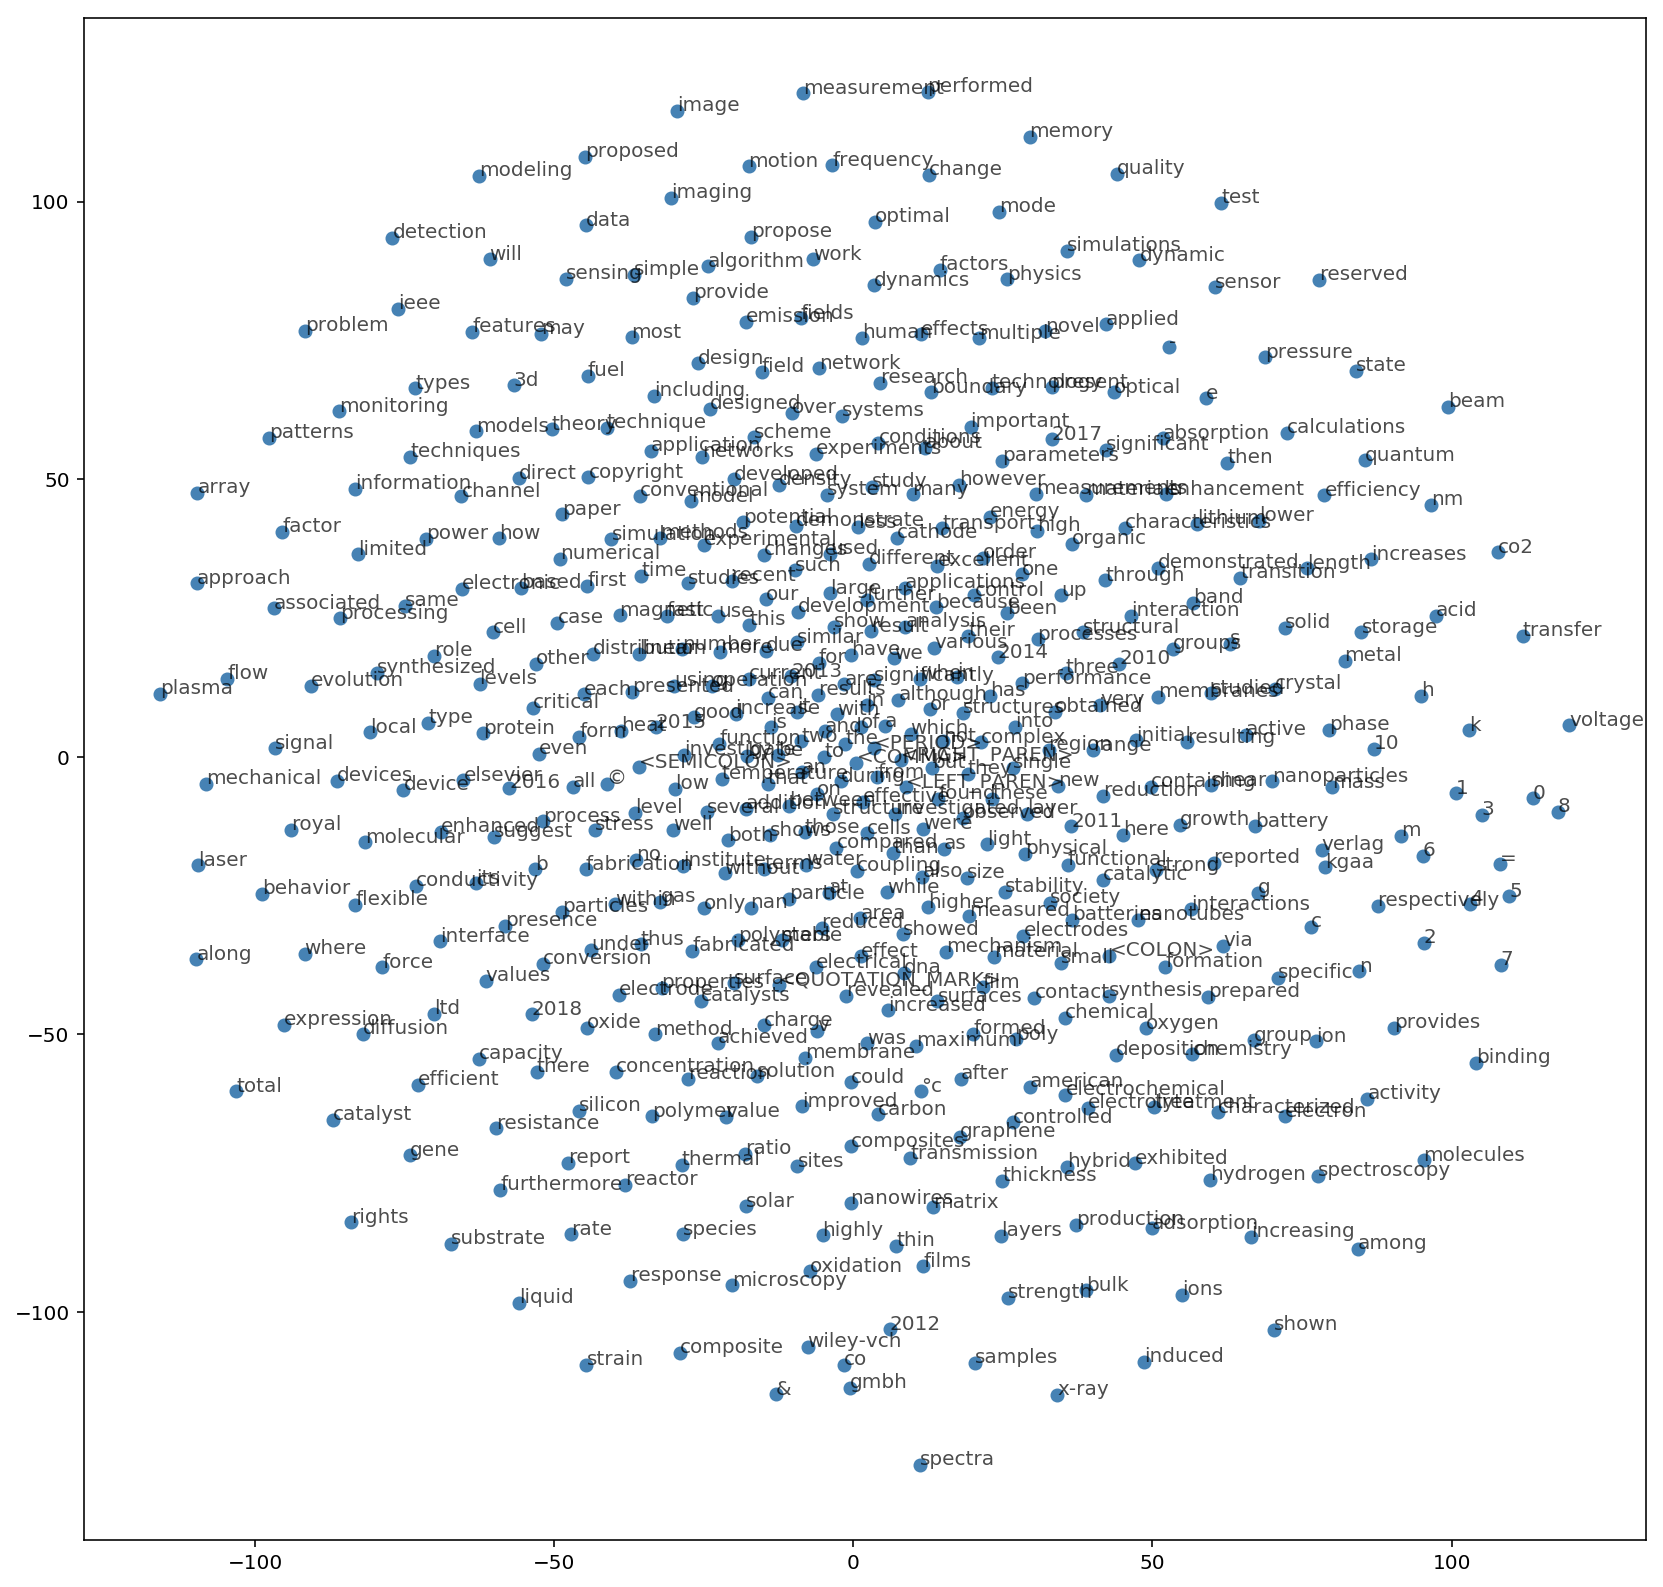

In [25]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)